<h2> Plot Wyoming Cloud Radar data</h2>

In [8]:
# Load the needed packages
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import mstats

import awot
from awot.graph import FlightLevel, RadarVerticalPlot, RadarUtilityPlot

%matplotlib inline

<b>Supply input data and plotting characteristics</b>

In [2]:
file1 = "WCR.TEST14.20140917.183235_185638.down.nc"
#file = "WCR.TEST14.20140618.200302_201559.up.nc"
wcrf1 = os.path.join("/Users/guy/data/king_air/test2014/wcr", file1)

file = "WCR.OWLES13.20140127.203210_210457.up-down.nc"
wcrf2 = os.path.join("/Users/guy/data/king_air/owles2013/wcr/", file)

start_time = "2014-01-27 20:35:00"
end_time = "2014-01-27 20:40:00"

# Set the project name
Project="TEST14"

#TEST2014
#altmin, altmax = 1500., 8000.

#OWLES2013
altmin, altmax = 0., 3000.

refmin, refmax = -50., 30.
#velmin, velmax = -16., 16. # Nyquist
velmin, velmax = -3., 3. # Nyquist

<b>Read in the radar data</b>

In [3]:
wcr = awot.io.read_wcr2(fname=wcrf2)

height_zdr does not exist in file...
height_ldr does not exist in file...
zdr does not exist in file...
ldr does not exist in file...


In [4]:
print(wcr.keys())
print("Reflectivity Min/Max = %f / %f \n"
      "Velocity Min/Max = %f / %f \n"
      "Altitude Min/Max = %f / %f \n"
      "Height Min/Max = %f / %f \n"
      "Surface Min/Max = %f / %f \n"%(
        wcr['fields']['reflectivity']['data'].min(),wcr['fields']['reflectivity']['data'].max(),
        wcr['fields']['velocity']['data'].min(),wcr['fields']['velocity']['data'].max(),
        wcr['altitude']['data'].min(), wcr['altitude']['data'].max(),
        wcr['height']['data'].min(), wcr['height']['data'].max(),
        wcr['surface']['data'].min(), wcr['surface']['data'].max()))
print(wcr['time']['data'].min(), wcr['time']['data'].max())

print(wcr['fields']['reflectivity']['data'][:,0,...].shape)
#wcr['fields']['reflectivity']['data'].shape, data['data'].shape
#qArr = mstats.mquantiles(wcr['fields']['reflectivity']['data'], prob=[5, 10, 25, 50, 75, 90, 95], axis=0)

['fields', 'tas', 'ground_speed', 'aircraft_wind', 'reflectivity_minimum', 'data_format', 'longitude', 'height', 'project', 'platform', 'flight_number', 'height_ldr', 'surface', 'aspect', 'time', 'latitude', 'altitude', 'height_zdr', 'beam_vector', 'metadata']
Reflectivity Min/Max = -54.610954 / 46.513153 
Velocity Min/Max = -15.402483 / 15.429156 
Altitude Min/Max = 1013.030029 / 2786.558594 
Height Min/Max = 66.791504 / 2905.298340 
Surface Min/Max = 0.000000 / 592.440918 

(datetime.datetime(2014, 1, 27, 20, 32, 10, 876783), datetime.datetime(2014, 1, 27, 21, 4, 56, 766817))
(9750,)


<b>Make a vertical plot of reflectivity and velocity fields. Subset the first plot.</b>

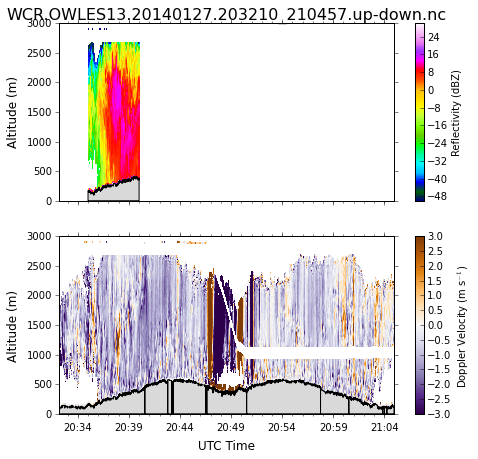

In [9]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7.5,7), sharex=True)

wcr_vp= RadarVerticalPlot(wcr)

wcr_vp.time_height_image('reflectivity', ax=ax1, plot_log10_var=False,
              start_time=start_time, end_time=end_time,
                         vmin=refmin, vmax=refmax,
                         fill_surface=True,
                         cb_label=r'Reflectivity (dBZ)',
                         height_min=altmin, height_max=altmax, title=file,
                         ylab=r'Altitude (m)', ylabFontSize=12)
              
wcr_vp.time_height_image('velocity', ax=ax2, plot_log10_var=False,
#              start_time=start_time, end_time=end_time,
                         vmin=velmin, vmax=velmax,
                         fill_surface=True,
                         cmap="PuOr_r",
                         cb_label=r'Doppler Velocity (m s$^{-1}$)',
                         height_min=altmin, height_max=altmax,
                         ylab=r'Altitude (m)', ylabFontSize=12,
                         xlab='UTC Time', xlabFontSize=12)

<b>Now subset the second plot and apply discrete binned levels</b>

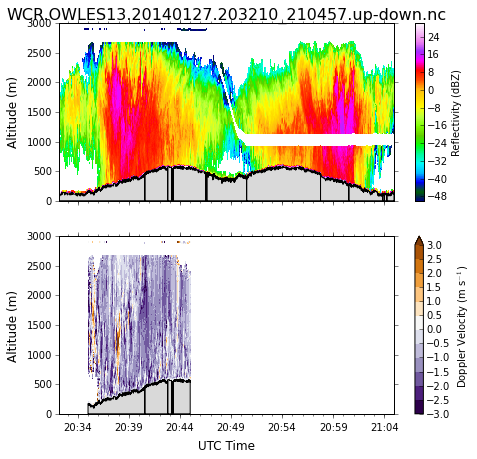

In [6]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7.5,7), sharex=True)

wcr_vp= RadarVerticalPlot(wcr)

wcr_vp.time_height_image('reflectivity', ax=ax1, plot_log10_var=False,
                         vmin=refmin, vmax=refmax,
                         fill_surface=True,
                         cb_label=r'Reflectivity (dBZ)',
                         height_min=altmin, height_max=altmax, title=file,
                         ylab=r'Altitude (m)', ylabFontSize=12)
              
wcr_vp.time_height_image('velocity', ax=ax2, plot_log10_var=False,
                         start_time=start_time, end_time="2014-01-27 20:45:00",
                         vmin=velmin, vmax=velmax,
                         fill_surface=True,
                         cmap="PuOr_r", discrete_cmap_levels=np.linspace(-3, 3, num=13),
                         cb_label=r'Doppler Velocity (m s$^{-1}$)',
                         height_min=altmin, height_max=altmax,
                         ylab=r'Altitude (m)', ylabFontSize=12,
                         xlab='UTC Time', xlabFontSize=12)

<b>Add a ground track distance to the Radar instance and apply instead of time series.</b>

In [6]:
tg = awot.util.calc_ground_distance(wcr, method='great circle', add_to_dict=True)

Minimum value of reflectivity = -54.611
Maximum value of reflectivity = 46.5132
Minimum value of velocity = -15.4025
Maximum value of velocity = 15.4292


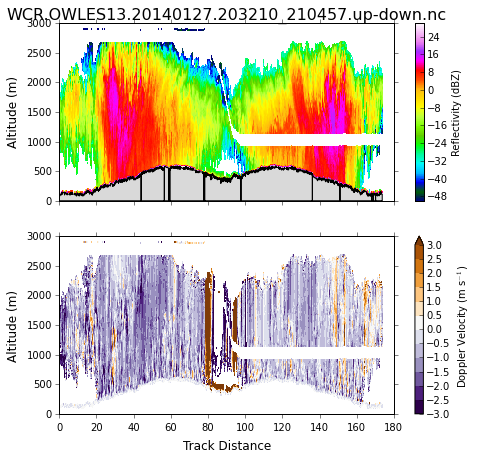

In [7]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7.5,7), sharex=True)

wcr_vp.track_height_image('reflectivity', track_key='track_distance_ground', plot_track_km=True,
                          plot_log10_var=False, vmin=refmin, vmax=refmax,
                          fill_surface=True,
                          cb_label=r'Reflectivity (dBZ)',
                          height_min=altmin, height_max=altmax, title=file,
                          ylab=r'Altitude (m)', ylabFontSize=12, ax=ax1)
              
wcr_vp.track_height_image('velocity', track_key='track_distance_ground', plot_track_km=True,
                          vmin=velmin, vmax=velmax,
#                          fill_surface=True,
                          cmap="PuOr_r", discrete_cmap_levels=np.linspace(-3, 3, num=13),
                          cb_label=r'Doppler Velocity (m s$^{-1}$)',
                          height_min=altmin, height_max=altmax,
                          ylab=r'Altitude (m)', ylabFontSize=12,
                          xlab='Track Distance', xlabFontSize=12, ax=ax2)

<b>Subset by time and plot in track distance</b>

Minimum value of reflectivity = -54.0004
Maximum value of reflectivity = 46.5132
Minimum value of velocity = -9.82693
Maximum value of velocity = 5.47219


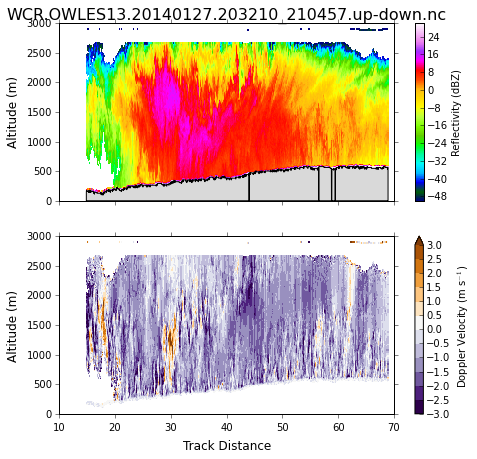

In [8]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7.5,7), sharex=True)

wcr_vp.track_height_image('reflectivity', track_key='track_distance_ground', plot_track_km=True,
                          plot_log10_var=False, vmin=refmin, vmax=refmax,
                          start_time=start_time, end_time="2014-01-27 20:45:00",
                          fill_surface=True,
                          cb_label=r'Reflectivity (dBZ)',
                          height_min=altmin, height_max=altmax, title=file,
                          ylab=r'Altitude (m)', ylabFontSize=12, ax=ax1)
              
wcr_vp.track_height_image('velocity', track_key='track_distance_ground', plot_track_km=True,
                          vmin=velmin, vmax=velmax,
                         start_time=start_time, end_time="2014-01-27 20:45:00",
#                          fill_surface=True,
                          cmap="PuOr_r", discrete_cmap_levels=np.linspace(-3, 3, num=13),
                          cb_label=r'Doppler Velocity (m s$^{-1}$)',
                          height_min=altmin, height_max=altmax,
                          ylab=r'Altitude (m)', ylabFontSize=12,
                          xlab='Track Distance', xlabFontSize=12, ax=ax2)

<b>You can also mix the types of plots in a panel. Make sure to turn off <i>sharex</i> if on and adjust the keywords accordingly. Note that due to scaling by Matplotlib</b>

Minimum value of reflectivity = -54.0004
Maximum value of reflectivity = 46.5132


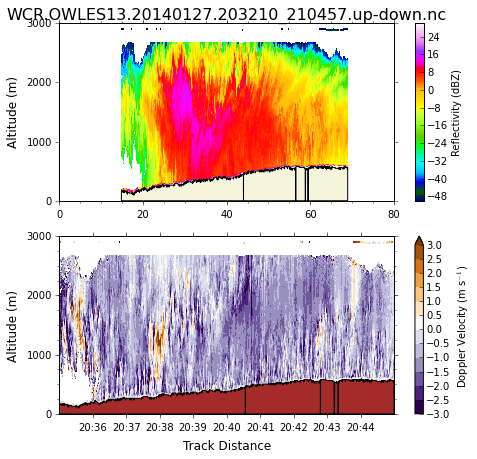

In [7]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7.5,7), sharex=False)

wcr_vp.track_height_image('reflectivity', track_key='track_distance_ground', plot_track_km=True,
                          plot_log10_var=False, vmin=refmin, vmax=refmax,
                          start_time=start_time, end_time="2014-01-27 20:45:00",
                          track_MinTicks=5., track_MajTicks=20.,
                          height_MajTicks=1000.,
                          fill_surface=True, fill_color='beige',
                          cb_label=r'Reflectivity (dBZ)',
                          height_min=altmin, height_max=altmax, title=file,
                          ylab=r'Altitude (m)', ylabFontSize=12, ax=ax1)
              
wcr_vp.time_height_image('velocity',
                         vmin=velmin, vmax=velmax,
                         start_time=start_time, end_time="2014-01-27 20:45:00",
                         height_MinTicks=250., height_MajTicks=1000.,
                         fill_surface=True, fill_color='brown',
                         cmap="PuOr_r", discrete_cmap_levels=np.linspace(-3, 3, num=13),
                         cb_label=r'Doppler Velocity (m s$^{-1}$)',
                         height_min=altmin, height_max=altmax,
                         ylab=r'Altitude (m)', ylabFontSize=12,
                         xlab='Track Distance', xlabFontSize=12, ax=ax2)

<b>Instantiate a RadarUtilityPlot instance for frequency calculations.</b>

In [7]:
wcr_util = RadarUtilityPlot(wcr)

<b>Now we can produce a bivariate frequency distribution using AWOT. The plot uses the RadarUtilityPlot class.</b>

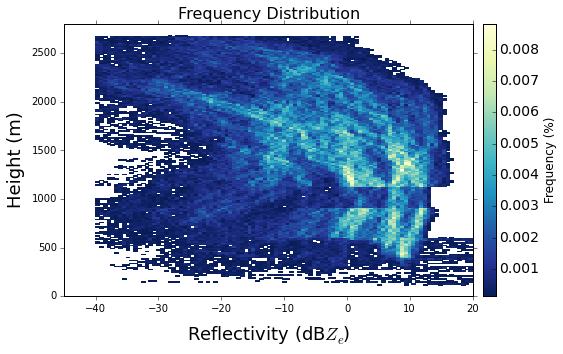

In [8]:
figC, axC0 = plt.subplots(1, 1, figsize=(8, 5))

biv = wcr_util.plot_bivariate_frequency('reflectivity', 'height', start_time=start_time, end_time=end_time,
                                        xbinsminmax=(-40., 20.), ybinsminmax=(0., 3000.), nbinsx=100, nbinsy=390,
                                        mask_below=0.00001, plot_colorbar=True, plot_percent=True,
                                        x_min=-45., x_max=20., y_min=0, y_max = 2800.,
                                        xlab= "Reflectivity (dB${Z}$$_{e}$)", ylab="Height (m)", xpad=10,
                                        xlabFontSize=18, ylabFontSize=18,
                                        title="Frequency Distribution", titleFontSize=16,
                                        cb_fontsize=12, cb_ticklabel_size=14, cb_pad=.02, cmap='YlGnBu_r',
                                        ax=axC0, fig=figC)
#wcr_util.plot_quantiles('reflectivity', quantiles=[5, 10, 25, 50, 75, 90, 95], height_axis=1, 
#                        setup_axes=False, ax=axC0)

figC.tight_layout()

<b>Produce CFADs - caclulating frequency at every height.</b>

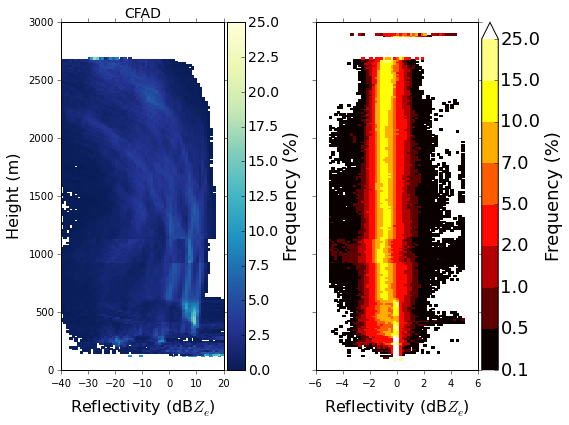

In [22]:
figC, (axZ, axW) = plt.subplots(1, 2, sharey=True, figsize=(8,6))

cfadZ = wcr_util.plot_cfad('reflectivity', height_axis=1,
                           xbinsminmax=(-40., 20.), nbinsx=61, plot_percent=True, plot_colorbar=True,
                           vmin=0., vmax=25,
                           xlab= "Reflectivity (dB${Z}$$_{e}$)", ylab="Height (m)", xpad=10,
                           xlabFontSize=16, ylabFontSize=16,
                           title="CFAD", titleFontSize=14,
                           cb_fontsize=18, cb_ticklabel_size=14, cb_pad=.02, cmap='YlGnBu_r',
                           mask_below=.01, ax=axZ)
cfadW = wcr_util.plot_cfad('velocity', height_axis=1,
                           xbinsminmax=(-5., 5.), nbinsx=51, plot_percent=True, plot_colorbar=True,
                           discrete_cmap_levels= [.1, .5, 1, 2, 5, 7, 10, 15, 25],
                           xlab= "Reflectivity (dB${Z}$$_{e}$)", xpad=10, xlabFontSize=16,
                           cb_fontsize=18, cb_ticklabel_size=18, cb_pad=.02, cmap='hot',
                           mask_below=.01, ax=axW)
figC.tight_layout()

Produce CFAD for time subset of flight

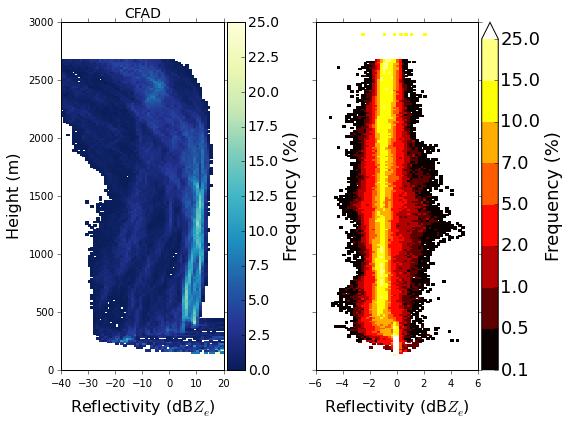

In [21]:
figC, ((axZ1, axW1)) = plt.subplots(1, 2, sharey=True, figsize=(8,6))

wcr_util.plot_cfad('reflectivity', height_axis=1, start_time=start_time, end_time=end_time,
                   xbinsminmax=(-40., 20.), nbinsx=61, plot_percent=True, plot_colorbar=True,
                   vmin=0., vmax=25,
                   xlab= "Reflectivity (dB${Z}$$_{e}$)", ylab="Height (m)", xpad=10,
                   xlabFontSize=16, ylabFontSize=16,
                   title="CFAD", titleFontSize=14,
                   cb_fontsize=18, cb_ticklabel_size=14, cb_pad=.02, cmap='YlGnBu_r',
                    mask_below=.01, ax=axZ1)
wcr_util.plot_cfad('velocity', height_axis=1, start_time=start_time, end_time=end_time,
                   xbinsminmax=(-5., 5.), nbinsx=51, plot_percent=True, plot_colorbar=True,
                   discrete_cmap_levels= [.1, .5, 1, 2, 5, 7, 10, 15, 25],
                   xlab= "Reflectivity (dB${Z}$$_{e}$)", xpad=10, xlabFontSize=16,
                   cb_fontsize=18, cb_ticklabel_size=18, cb_pad=.02, cmap='hot',
                   mask_below=.01, ax=axW1)
figC.tight_layout()

<b>For fun let's reverse the time axis, because python is that cool</b>

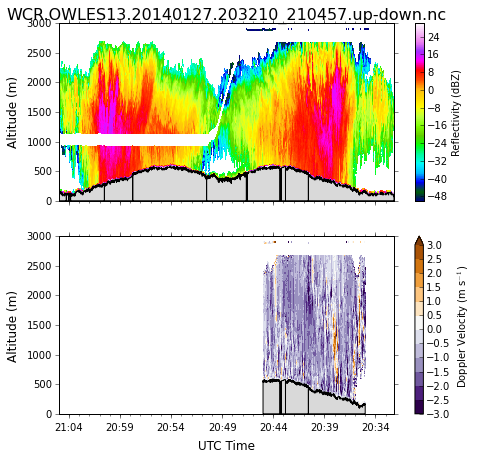

In [10]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7.5,7), sharex=True)

wcr_vp= RadarVerticalPlot(wcr)

wcr_vp.time_height_image('reflectivity', ax=ax1, plot_log10_var=False,
                         vmin=refmin, vmax=refmax,
                         fill_surface=True,
                         cb_label=r'Reflectivity (dBZ)',
                         height_min=altmin, height_max=altmax, title=file,
                         ylab=r'Altitude (m)', ylabFontSize=12)
              
wcr_vp.time_height_image('velocity', ax=ax2, plot_log10_var=False,
                         start_time=start_time, end_time="2014-01-27 20:45:00",
                         vmin=velmin, vmax=velmax,
                         fill_surface=True,
                         cmap="PuOr_r", discrete_cmap_levels=np.linspace(-3, 3, num=13),
                         cb_label=r'Doppler Velocity (m s$^{-1}$)',
                         height_min=altmin, height_max=altmax,
                         ylab=r'Altitude (m)', ylabFontSize=12,
                         xlab='UTC Time', xlabFontSize=12)
ax1.invert_xaxis()